In [2]:
from copy import deepcopy
from typing import Optional
import cv2
from matplotlib import pyplot as plt
from operator import itemgetter
import keras
BLANK = 0

ImportError: Traceback (most recent call last):
  File "c:\miniconda3\envs\sudoku\lib\site-packages\tensorflow\python\pywrap_tensorflow.py", line 62, in <module>
    from tensorflow.python._pywrap_tensorflow_internal import *
ImportError: DLL load failed while importing _pywrap_tensorflow_internal: A dynamic link library (DLL) initialization routine failed.


Failed to load the native TensorFlow runtime.
See https://www.tensorflow.org/install/errors for some common causes and solutions.
If you need help, create an issue at https://github.com/tensorflow/tensorflow/issues and include the entire stack trace above this error message.

In [ ]:
BoardSuperposition = list[list[set[int] | int]]
Square = tuple[int, int]

# ConstraintBoard's con_board is a 2D list of where con_board[x][y] is a set of possible numbers in the square
class ConstraintBoard:
    """
    A ConstraintBoard represents a Sudoku board, where the set at x, y in its con_board represents all the
    possible numbers for the blank square at row x, column y in the corresponding Sudoku.
    If instead conv_board[x][y] is an integer, it represents a filled square.
    """
    def __init__(self, box_size: int = 3, coords: list[tuple[int, int, int]] = None, matrix: list[list[int]] = None):
        self.box_size = box_size
        self.length = box_size**2
        # Initialise a blank board with all possible numbers for each square
        self.con_board = [[set(range(1, self.length+1)) 
                            for _ in range(self.length)] for _ in range(self.length)]
        if coords:
            self.board_from_coords(coords)
        elif matrix:
            self.board_from_matrix(matrix)
                        
    def board_from_coords(self, coords: list[tuple[int, int, int]]):
        """
        Initialise a board from a list of square coordinates and numbers
        """
        for (x, y, num) in coords: 
            self.con_board = self.fill_square((x, y), num, self.con_board)

    def board_from_matrix(self, matrix: list[list[int]]):
        """
        Intialise a board from a 2D list representing squares in a Sudoku board
        """
        for x in range(len(matrix)):
            for y in range(len(matrix[x])):
                num = matrix[x][y]
                if num != BLANK:
                    self.con_board = self.fill_square((x, y), num, self.con_board)

    def solve(self, board: BoardSuperposition) -> Optional[BoardSuperposition]:
        """
        Recursively fill in squares, backtracking if necessary until a solution is achieved
        """
        square = self.get_next_empty(board)
        # We've solved it!
        if not square:
            return board

        options = board[square[0]][square[1]]
        # Recursively split to try every possible number for the given square
        for option in options:
            new_board = self.fill_square(square, option, board)
            # The new_board is None when it's unsolvable
            if not new_board:
                continue
            solution = self.solve(new_board)
            # Only care about the first solution
            if solution:
                return solution
        # The given board is unsolvable
        return None
    
    def get_next_empty(self, board: BoardSuperposition) -> Optional[Square]:
        """
        Find the next empty square with fewest possible numbers, return its coords as a tuple
        """
        best_square = None
        cur_fewest = self.length + 1

        for row in range(self.length):
            for col in range(self.length):
                if type(board[row][col])!=int:
                    if len(board[row][col]) < cur_fewest:
                        best_square = (row, col)
                        cur_fewest = len(board[row][col])
        return best_square

    def fill_square(self, square: Square, num: int, board: BoardSuperposition) -> Optional[Square]:
        """
        Fill in square in our board with num and remove it as possibility in other squares
        """
        new_board = deepcopy(board)
        squares = self.get_squares(square)
        for (x, y) in squares:
            # Skip over this square if it's already filled in
            if type(new_board[x][y])!=int:
                new_board[x][y].discard(num)
            # This square is unsolvable, need to backtrack
            if not new_board[x][y]:
                return None
        new_board[square[0]][square[1]] = num
        return new_board

    def get_squares(self, square: Square) -> set[Square]:
        """
        Gets the coordinates of every other square in the same row, column, and square
        """
        # Which box the square is in, e.g. (0, 0) is the top-leftmost box
        box = (square[0]//self.box_size, square[1]//self.box_size)
        indices = range(self.length)
        same_row = {(num, square[1]) for num in indices}
        same_col = {(square[0], num) for num in indices}
        same_box = {(self.box_size*box[0]+i, self.box_size*box[1]+j) 
                    for i in range(self.box_size) for j in range(self.box_size)}
        squares = same_row | same_col | same_box
        # Remove the original square, since it will be collapsed to a number
        squares.remove(square)
        return squares

In [8]:
# sample = [(0,4,8),(0,6,5),(1,0,2),(1,2,4),(1,5,3),(1,8,7),(2,7,9),(2,8,1),(3,0,6),(3,5,1),(4,1,2),(4,3,6),(4,4,9),
#          (4,5,8),(4,7,3),(5,3,3),(5,8,6),(6,0,7),(6,1,6),(7,0,8),(7,3,9),(7,6,2),(7,8,3),(8,2,3),(8,4,5)]
sample = [
 [0, 2, 8, 0, 0, 0, 9, 7, 0],
 [4, 0, 0, 9, 0, 6, 0, 0, 2],
 [9, 0, 0, 0, 0, 0, 0, 0, 4],
 [0, 5, 0, 0, 8, 0, 0, 2, 0],
 [0, 0, 0, 3, 0, 5, 0, 0, 0],
 [0, 1, 0, 0, 6, 0, 0, 3, 0],
 [1, 0, 0, 0, 0, 0, 0, 0, 9],
 [3, 0, 0, 7, 0, 1, 0, 0, 8],
 [0, 7, 2, 0, 0, 0, 1, 5, 0]]
original = ConstraintBoard(matrix = sample)
original.solve(original.con_board)

[[5, 2, 8, 1, 4, 3, 9, 7, 6],
 [4, 3, 1, 9, 7, 6, 5, 8, 2],
 [9, 6, 7, 5, 2, 8, 3, 1, 4],
 [7, 5, 3, 4, 8, 9, 6, 2, 1],
 [2, 4, 6, 3, 1, 5, 8, 9, 7],
 [8, 1, 9, 2, 6, 7, 4, 3, 5],
 [1, 8, 5, 6, 3, 2, 7, 4, 9],
 [3, 9, 4, 7, 5, 1, 2, 6, 8],
 [6, 7, 2, 8, 9, 4, 1, 5, 3]]

In [ ]:
# Load image
# Threshold image to binary
# Find contours
# Find square with largest area
# Apply perspective transform
# Get each individual square
# Use OCR to extract digits from non-empty cells
# Solve

class SudokuOCR:
    def image_to_sudoku(self, image_path):
        image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
        ret_val, thresholded = cv2.threshold(src=image, thresh=127, maxval=255, type=cv2.THRESH_BINARY)
        

In [43]:
SIDE_LENGTH = 9
image = cv2.imread("example sudoku.webp", cv2.IMREAD_COLOR)
grayscale = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
# Convert to a binary image, swapping white and black
ret_val, thresholded = cv2.threshold(src=grayscale, thresh=127, maxval=255, type=cv2.THRESH_BINARY_INV)
# Extract every object that is black in the original image
contours, hierarchy = cv2.findContours(thresholded, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
# Get the squares by extracting the 1st through 81st highest area shapes
squares = sorted(contours, 
                 key=cv2.contourArea, reverse=True)[1:SIDE_LENGTH**2+1]
# Find the leftmost and topmost coords for each square
maxes = [(square, min(square[:,0,0]), max(square[:,0,1])) for square in squares]
# Order the squares in a 2D list, from top to bottom, left to right
top_bottom = [sorted(maxes, key=itemgetter(2))[i:i+SIDE_LENGTH] for i in range(0, SIDE_LENGTH**2, SIDE_LENGTH)]
left_right = [sorted(row, key=itemgetter(1)) for row in top_bottom]
arranged = [[col[0] for col in row] for row in left_right]

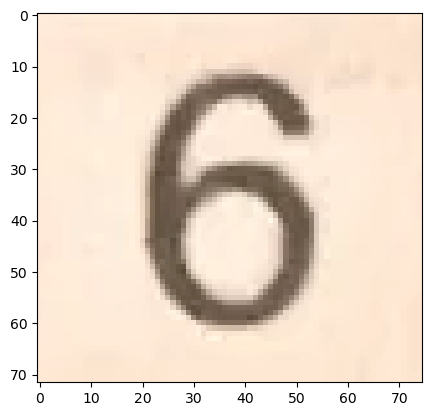

In [ ]:
contour = arranged[0][1]
# Extract the center of the square, cutting off the borders
x, y, w, h = cv2.boundingRect(contour)
x += int(0.1*w)
y += int(0.1*h)
w = int(0.8*w)
h = int(0.8*h)
contents = image[y:y+h, x:x+w]
